## SenNetworks: Hacking the Human Vasculature in 3D

### Exploratory notebook using Segformer and SAM

#### Results on test set set are still pending.

#### Notebook Author: Andrew Kettle

In [1]:
# Packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pandas as pd
import os
import shutil
import transformers # Hugging Face for Segformer models
import torch.optim.lr_scheduler as lr_scheduler

from tqdm import tqdm
from torchinfo import summary
from sklearn.model_selection import train_test_split
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

### Dataset
The following few cells implement the data ingestion functions for the kidney dataset. The dataset and dataloader are both implemented using the base PyTorch classes. 

In [30]:
# Dataset that is passed to dataloader
class SenDataset(torch.utils.data.Dataset):

	def __init__(self, run_type, feature_extractor):
		self.run_type = run_type
		self.feature_extractor = feature_extractor
		self.image_paths = []
		self.label_paths = []

	def setPaths(self, image_paths, label_paths):
		self.image_paths = image_paths

		# Guard
		if self.run_type != 'test':
			self.label_paths = label_paths

	def setImagePath(self, image_paths):
		self.image_paths = image_paths
	
	def importTif(self, path, gray: bool):
		image = cv2.imread(path) # Read
		if gray:
			# Grab a single channel for label
			image = cv2.imread(path)[:,:,0] # R=G=B, so index can be [0,1,2]

		return image

	def __len__(self):
		return len(self.image_paths)

	def __getitem__(self, idx):

		if self.run_type != 'test':
			# Grab image and label from disk
			image = self.importTif(self.image_paths[idx], False)
			label = self.importTif(self.label_paths[idx], True)

			# Scale label, do this because Segformer uses 255 as an "ignore index"
			label = (label / 255).astype('uint8') # Scale to [0,1]

			# Prepare inputs for segformer using SegformerImageProcessor
			encoded_inputs = self.feature_extractor(image, label, return_tensors='pt')
			for k,v in encoded_inputs.items():
				encoded_inputs[k].squeeze_() # remove batch axis

			# Only need image and labels for our implementation
			image = encoded_inputs['pixel_values']
			label = encoded_inputs['labels']

			return image, label

		else:
			# Grab image from disk (no label provided for test set)
			image = self.importTif(self.image_paths[idx], False)

			# Prepare inputs for segformer using SegformerImageProcessor
			encoded_inputs = self.feature_extractor(image, return_tensors='pt')
			for k,v in encoded_inputs.items():
				encoded_inputs[k].squeeze() # remove batch axis

			image = encoded_inputs['pixel_values']
			return image, ''

# Rename items in the dataset so there is no overlap (only run this once!)
def renameDataset():
	root_dir = os.path.join(os.getcwd(), "data")
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]

	# Iterate over each subset
	for p in paths:	
		
		image_path = os.path.join(p, "images")
		label_path = os.path.join(p, "labels")
		image_names = os.listdir(image_path)
		label_names = os.listdir(label_path)

		# Name to append for each file (splitting is platform specific)
		append_name = p.split('/')[-1]

		revised_image_names = [append_name + '_' + name for name in image_names]
		revised_label_names = [append_name + '_' + name for name in label_names]

		# Rename images
		for iname, upiname in zip(image_names, revised_image_names):
			shutil.move(os.path.join(image_path, iname), os.path.join(image_path, upiname))
		# Rename labels
		for lname, uplname in zip(label_names, revised_label_names):
			shutil.move(os.path.join(label_path, lname), os.path.join(label_path, uplname))

# Populate numpy array with necessary dataset information
def buildDataset(root_dir: str, run_type: str):
	""" Populate the image and label arrays

	Args:
		root_dir (str): Path to root dir (where training or testing may take place)
		run_type (str): either 'train' or 'test'
	"""

	image_paths = []
	label_paths = []

	# Logic for training or testing
	if run_type == 'train':
		working_dir = os.path.join(root_dir, "train")
	elif run_type == 'test':
		working_dir = os.path.join(root_dir, "test")
	else:
		print("Unsupported run_type in the buildDataset function")
		assert(False) # Quick hack to exit execution

	paths = os.listdir(working_dir)
	paths = [os.path.join(working_dir, p) for p in paths]

	for p in paths:

		image_path = os.path.join(p, "images")
		image_names = [os.path.join(image_path, name) for name in os.listdir(image_path)]
		image_paths.append(np.array(image_names))

		if run_type == 'train':
			label_path = os.path.join(p, "labels")
			label_names = [os.path.join(label_path, name) for name in os.listdir(label_path)]
			label_paths.append(np.array(label_names))
	
	image_paths = np.concatenate(image_paths)

	if run_type == 'train':
		label_paths = np.concatenate(label_paths)

	return image_paths, label_paths

In [3]:
# Cell for calculating the image mean and standard deviation of the dataset.
# We resize to 512x512 so that everything is standardized

def calcMeanAndStd():

	# Change paths if necessary!!
	root_dir = os.path.join(os.getcwd(), "data")
	train_dir = os.path.join(root_dir, "train")

	paths = os.listdir(train_dir)
	paths = [os.path.join(train_dir, p) for p in paths]

	us = 0
	stds = 0
	its = 0

	# Iterate over each subset
	for p in paths:	
		
		image_path = os.path.join(p, "images")
		image_names = os.listdir(image_path)

		for name in image_names:
			image = cv2.imread(os.path.join(image_path, name))
			image = cv2.resize(image, (512, 512))
			us = us + np.mean(image) 
			stds = stds + np.std(image) 
			its+=1

	print(us / float(its))
	print(stds / float(its))

#calcMeanAndStd()

In [35]:
# Ingest data, store in numpy arrays
Xtr, Ytr = buildDataset(os.path.join(os.getcwd(), 'data'), 'train')
print(f"Xtr.shape: {Xtr.shape} Ytr.shape: {Ytr.shape}")

#Xte, _ = buildDataset(os.path.join(os.getcwd(), 'data'), 'test')
#print(f"Xte.shape: {Xte.shape}")

Xtr.shape: (6,) Ytr.shape: (6,)


#### Cleaning

Observe that the training set has fewer labels than images (Depends on which kidney folders are being used). Since we are data rich, we will elect to toss out the samples that don't have labels for the sake of simplicity.

In [36]:
# Trim file extensions
a = np.array([x.split('.')[0].split('/')[-1] for x in Xtr])
b = np.array([y.split('.')[0].split('/')[-1] for y in Ytr])

# Find overlap
c = np.where(np.intersect1d(a, b))

# Drop extra items from training set
Xtr = Xtr[c]

Split data into training and testing using 80/20 split

In [37]:
# Split dataset into training and validation, normally test_size=0.2, but set 
# test-size = 0.5 so valds has at least 3 images even using toy dataset
#Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=0.2, shuffle=True)
Xtr, Xval, Ytr, Yval = train_test_split(Xtr, Ytr, test_size=0.5, shuffle=True)
print(f"Xtr: {Xtr.shape}, Ytr: {Ytr.shape}")
print(f"Xval: {Xval.shape}, Yval: {Yval.shape}")

Xtr: (3,), Ytr: (3,)
Xval: (3,), Yval: (3,)


#### Create dataset and dataloader

In [38]:
# Numbers extracted from mean and std calculation function
# Using default imagenet mean and stddev because those are working better
image_mean = 103.84
image_std = 7.92

# Create preprocessing routine for segformer (sometimes called feature_extractor)
feature_extractor_train = transformers.SegformerImageProcessor()
feature_extractor_test = transformers.SegformerImageProcessor(do_normalize=False) # Test images shouldn't know about training

# Create datasets and set paths
trds = SenDataset('train', feature_extractor_train)
trds.setPaths(Xtr, Ytr)

valds = SenDataset('validation', feature_extractor_train)
valds.setPaths(Xval, Yval)

#teds = SenDataset('test', feature_extractor_test)
#teds.setImagePath(Xte)

# Maximum size that an RTX3080 with 12GB VRAM could handle.
# NOTE: Graders / TAs, you may have to change this if your hardware is less performant.  
batch_size = 8

train_loader = torch.utils.data.DataLoader(trds, batch_size=batch_size, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valds, batch_size=batch_size, num_workers=4)
#test_loader = torch.utils.data.DataLoader(teds, batch_size=1) # Batch size 1 for testing

Image Size: torch.Size([3, 512, 512])
Label Size: torch.Size([512, 512])
Unique Label Values: [0 1]


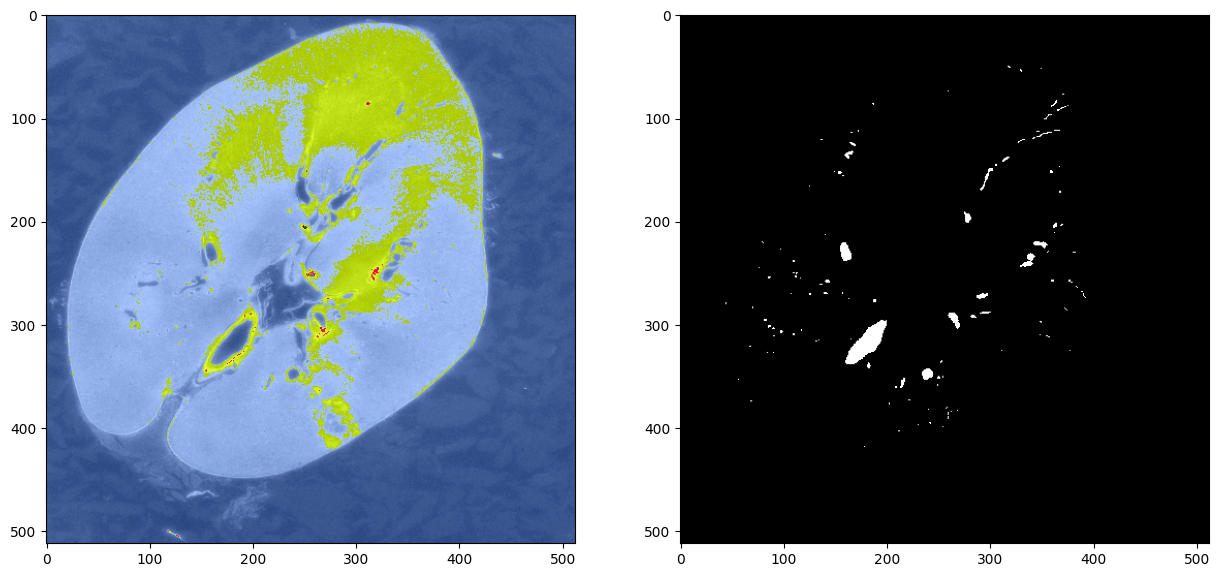

In [39]:
# Cell for sanity checking dataset methods

# Grab item from training dataset
image, label = trds.__getitem__(1)

# Ensure shapes are correct
print(f"Image Size: {image.shape}")
print(f"Label Size: {label.shape}")

# Convert to numpy for display
image = image.numpy()
label = label.numpy()

# Check that labels are in correct range
print(f"Unique Label Values: {np.unique(label)}") # Should be 0 or 1

# Reshape for display
image = np.moveaxis(image, 0, -1)
image = (image * 255).astype('uint8') # Image after norm

# Display image
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(image)
ax[1].imshow(label, cmap='gray')
plt.show()

## Implement Segformer on the Vascular Dataset

### Loss Function Implementations for training

These loss functions are not used in the current iteration of the notebook. I was experimenting with them earlier, but I have modified other parts of the notebook so these should be verified before use.

In [40]:
# Pytorch Dice Loss Implmentation Modified from: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch
# DiceLoss for cross entropy loss (assumes num_classes > 1)
class DiceLoss(torch.nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        # Compute logits from sigmoid
        logits = torch.sigmoid(inputs)       

        # Compute softmax from logits
        sig = torch.sigmoid(logits)
        softmax = F.softmax(sig, dim=1) # Compute softmax to get probs

        probs, _ = torch.max(softmax, dim=1)

        # Seg cts in [0,1], masks discrete one-hot with labels [0,1]
        intersection = (probs * targets).sum()
        dice = (2. * intersection + 1) / (probs.sum() + targets.sum() + 1)
        
        return 1 - dice

# Weighted cross entropy loss using unnormalized logits, not being used
# TODO: Bug check this function
class WeightedCE(torch.nn.Module):
    def __init__(self, weights):
        super(WeightedCE, self).__init__()
        self.weights = weights
        self.criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights[1]))

    def forward(self, logits, targets):

        # Copmpute sigmoid and softmax explicitly
        sig = torch.sigmoid(logits)
        softmax = F.softmax(logits, dim=1) # Compute softmax to get probs
        probs, _ = torch.max(softmax, dim=1)

        probs = probs.flatten()
        targets = torch.flatten(targets)

        loss = (-1 * self.weights[1] * targets * torch.log(probs)) - (self.weights[0] * (1 - targets) * torch.log(1 - targets))
        return torch.mean(loss)

In [41]:
# Adopted from here: https://github.com/huggingface/transformers/issues/15819 (Thanks Niels!)

class SegFormerCustom(transformers.SegformerPreTrainedModel):
	def __init__(self, config, pretrained):
		super().__init__(config)
		self.segformer = transformers.SegformerForSemanticSegmentation.from_pretrained(pretrained, num_labels=config.num_labels)
		self.pretrained_path = pretrained
		self.num_labels = config.num_labels
		#self.loss_func = WeightedCE(torch.tensor([1, 1]))

	def forward(self, pixel_values, labels=None):
		# get raw logits from segformer model
		outputs = self.segformer(pixel_values, labels)
		return outputs.logits, outputs.loss

		# If you would like to use a custom loss function, uncomment the code below and remove the return above
		# Works by bypassing the segformer loss and caculating loss using the 
		# unnormalized logits directly
		"""
		logits = outputs.logits
		loss = None
		if labels is not None: # Training
			upsampled_logits = F.interpolate(logits,
					size=pixel_values.size()[2:], # (height, width)
					mode='bilinear',
					align_corners=False)

			# Compute DiceBCE loss using logits from segformer
			loss = self.loss_func(upsampled_logits, labels.float())

		return logits, loss
		"""

In [177]:
# Create configuration for Segformer Model
config = transformers.SegformerConfig(num_labels=1) # 1 label = binary classification

# Grab pretrained model
# Use mit-b0 right now because it is the most lightweight
model = SegFormerCustom(config, 'nvidia/mit-b0')

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_var', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.3.proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [179]:
# Move model to GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device
model = model.to(device) # Send model to device before creating optimizer

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000006) # Segformer Default LR: 0.000006

# Learning Rate Scheduler. Not in use right now because of transfer learning
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

In [180]:
# Training Loop
total_steps = len(train_loader)
epochs = 60

train_loss_avg = []
val_loss_avg = []

# Train network
for ep in range(epochs):

	per_epoch_loss_train = []
	per_epoch_loss_val = []

	# Training
	for idx, (images, masks) in enumerate(tqdm(train_loader)):
		# Convert vars to GPU
		images = images.float().to(device)
		masks = masks.type(torch.LongTensor).to(device)

		output = model(pixel_values=images, labels=masks)
		loss = output[1]
		loss.backward()

		optimizer.step()
		optimizer.zero_grad()

		# Save batches loss
		per_epoch_loss_train.append(loss.item())

	print(f"Epoch: {ep}: Training Loss: {np.mean(np.array(per_epoch_loss_train))}")

	# Validation
	for idx, (images, masks) in enumerate(tqdm(valid_loader)):
		# Convert vars to GPU
		images = images.float().to(device)
		masks = masks.type(torch.LongTensor).to(device)

		output = model(pixel_values=images, labels=masks)
		loss = output[1]

		# Save batches loss
		per_epoch_loss_val.append(loss.item())

	scheduler.step()
	
	train_loss_avg.append(np.mean(np.array(per_epoch_loss_train)))
	val_loss_avg.append(np.mean(np.array(per_epoch_loss_val)))

# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

100%|██████████| 228/228 [00:32<00:00,  6.95it/s]


Epoch: 0: Training Loss: 0.21316270992617337


100%|██████████| 228/228 [00:32<00:00,  6.95it/s]


Epoch: 1: Training Loss: 0.0407308753612533


100%|██████████| 228/228 [00:32<00:00,  6.95it/s]


Epoch: 2: Training Loss: 0.0289306702999104


100%|██████████| 228/228 [00:32<00:00,  6.96it/s]


Epoch: 3: Training Loss: 0.024769852697653204


100%|██████████| 228/228 [00:33<00:00,  6.89it/s]


Epoch: 4: Training Loss: 0.02275081562989375


100%|██████████| 228/228 [00:33<00:00,  6.86it/s]


Epoch: 5: Training Loss: 0.021363027361139916


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 6: Training Loss: 0.020129600850244362


100%|██████████| 228/228 [00:32<00:00,  7.00it/s]


Epoch: 7: Training Loss: 0.018754758320650773


100%|██████████| 228/228 [00:32<00:00,  7.08it/s]


Epoch: 8: Training Loss: 0.01718050580810788


100%|██████████| 228/228 [00:32<00:00,  7.06it/s]


Epoch: 9: Training Loss: 0.015861353806318028


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 10: Training Loss: 0.014989914925025547


100%|██████████| 228/228 [00:32<00:00,  6.92it/s]


Epoch: 11: Training Loss: 0.014375962926638558


100%|██████████| 228/228 [00:33<00:00,  6.79it/s]


Epoch: 12: Training Loss: 0.013819545131634203


100%|██████████| 228/228 [00:33<00:00,  6.88it/s]


Epoch: 13: Training Loss: 0.013199153088703099


100%|██████████| 228/228 [00:33<00:00,  6.78it/s]


Epoch: 14: Training Loss: 0.012419121811705592


100%|██████████| 228/228 [00:32<00:00,  6.93it/s]


Epoch: 15: Training Loss: 0.011537951058830674


100%|██████████| 228/228 [00:32<00:00,  7.07it/s]


Epoch: 16: Training Loss: 0.010685334950195332


100%|██████████| 228/228 [00:31<00:00,  7.13it/s]


Epoch: 17: Training Loss: 0.009944624124552336


100%|██████████| 228/228 [00:31<00:00,  7.14it/s]


Epoch: 18: Training Loss: 0.009338991128300366


100%|██████████| 228/228 [00:32<00:00,  7.12it/s]


Epoch: 19: Training Loss: 0.008856835877196047


100%|██████████| 228/228 [00:31<00:00,  7.15it/s]


Epoch: 20: Training Loss: 0.008612479344663913


100%|██████████| 228/228 [00:31<00:00,  7.13it/s]


Epoch: 21: Training Loss: 0.00857195714611168


100%|██████████| 228/228 [00:32<00:00,  7.12it/s]


Epoch: 22: Training Loss: 0.00853226803296262


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 23: Training Loss: 0.008492136201535334


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 24: Training Loss: 0.008451608568225709


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 25: Training Loss: 0.008410810548076896


100%|██████████| 228/228 [00:32<00:00,  7.11it/s]


Epoch: 26: Training Loss: 0.008369875520369724


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 27: Training Loss: 0.008328957488278351


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 28: Training Loss: 0.00828816339561487


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 29: Training Loss: 0.008247618039604276


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 30: Training Loss: 0.008207459260072363


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 31: Training Loss: 0.008167755442851206


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 32: Training Loss: 0.008128662065709042


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 33: Training Loss: 0.008090201555955502


100%|██████████| 228/228 [00:32<00:00,  7.11it/s]


Epoch: 34: Training Loss: 0.008052440128379027


100%|██████████| 228/228 [00:32<00:00,  7.12it/s]


Epoch: 35: Training Loss: 0.008015412375690383


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 36: Training Loss: 0.007979154131342574


100%|██████████| 228/228 [00:32<00:00,  7.12it/s]


Epoch: 37: Training Loss: 0.007943691953346786


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 38: Training Loss: 0.007909032255778775


100%|██████████| 228/228 [00:32<00:00,  7.10it/s]


Epoch: 39: Training Loss: 0.007875210739337234


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 40: Training Loss: 0.007853975901461877


100%|██████████| 228/228 [00:32<00:00,  6.92it/s]


Epoch: 41: Training Loss: 0.007850091586812612


100%|██████████| 228/228 [00:32<00:00,  7.00it/s]


Epoch: 42: Training Loss: 0.007846639229172612


100%|██████████| 228/228 [00:32<00:00,  6.95it/s]


Epoch: 43: Training Loss: 0.0078432003634557


100%|██████████| 228/228 [00:32<00:00,  7.02it/s]


Epoch: 44: Training Loss: 0.007839738518988159


100%|██████████| 228/228 [00:32<00:00,  7.05it/s]


Epoch: 45: Training Loss: 0.007836260799146993


100%|██████████| 228/228 [00:32<00:00,  7.08it/s]


Epoch: 46: Training Loss: 0.007832779044595858


100%|██████████| 228/228 [00:32<00:00,  7.07it/s]


Epoch: 47: Training Loss: 0.007829277770054576


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 48: Training Loss: 0.00782576946361938


100%|██████████| 228/228 [00:32<00:00,  7.06it/s]


Epoch: 49: Training Loss: 0.007822253809743478


100%|██████████| 228/228 [00:32<00:00,  7.07it/s]


Epoch: 50: Training Loss: 0.007818738560257643


100%|██████████| 228/228 [00:32<00:00,  6.98it/s]


Epoch: 51: Training Loss: 0.007815225183628826


100%|██████████| 228/228 [00:32<00:00,  7.06it/s]


Epoch: 52: Training Loss: 0.007811714235382776


100%|██████████| 228/228 [00:32<00:00,  6.99it/s]


Epoch: 53: Training Loss: 0.007808205377506583


100%|██████████| 228/228 [00:32<00:00,  6.96it/s]


Epoch: 54: Training Loss: 0.0078047109347065555


100%|██████████| 228/228 [00:32<00:00,  7.09it/s]


Epoch: 55: Training Loss: 0.007801210507750511


100%|██████████| 228/228 [00:33<00:00,  6.73it/s]


Epoch: 56: Training Loss: 0.007797722759852676


100%|██████████| 228/228 [00:32<00:00,  6.95it/s]


Epoch: 57: Training Loss: 0.007794250423709552


100%|██████████| 228/228 [00:31<00:00,  7.25it/s]


Epoch: 58: Training Loss: 0.007790776478175662


100%|██████████| 228/228 [00:31<00:00,  7.25it/s]


Epoch: 59: Training Loss: 0.007787325638019594


100%|██████████| 57/57 [00:05<00:00, 10.58it/s]


In [181]:
# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

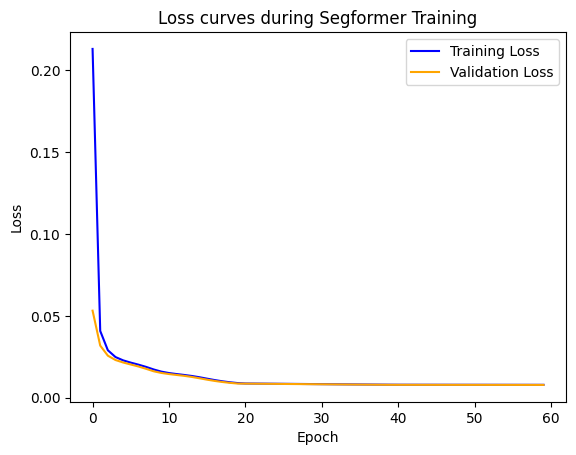

In [183]:
# Plot results
plt.plot(range(0, len(train_loss_avg)), train_loss_avg, label="Training Loss", color="blue")
plt.plot(range(0, len(val_loss_avg)), val_loss_avg, label="Validation Loss", color="orange")
plt.title("Loss curves during Segformer Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [103]:
# Save entire trained model to disk
torch.save(model, 'segformer-b0-kidney-1.pt')

In [42]:
# Load a segformer model for testing (if desired)
model = torch.load('model/segformer-b0-kidney-1.pt')

device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device
model = model.to(device) # Send model to device before creating optimizer

### Test Trained Segformer Model

In [43]:
# Decode outputs from Segformer's unnormalized logits

def decodeSegformer(logits, mask):
	
	upsampled_logits = F.interpolate(logits,
		size=image.size()[2:], # (height, width)
		mode='bilinear',
		align_corners=False)

	probs = torch.sigmoid(upsampled_logits)

	# Seg cts in [0,1], masks discrete one-hot with labels [0,1]
	intersection = (probs * mask).sum()
	dice = (2. * intersection + 1) / (probs.sum() + mask.sum() + 1)

	# pred above .5 = 1, below = 0
	seg = np.round(probs)

	return seg, dice

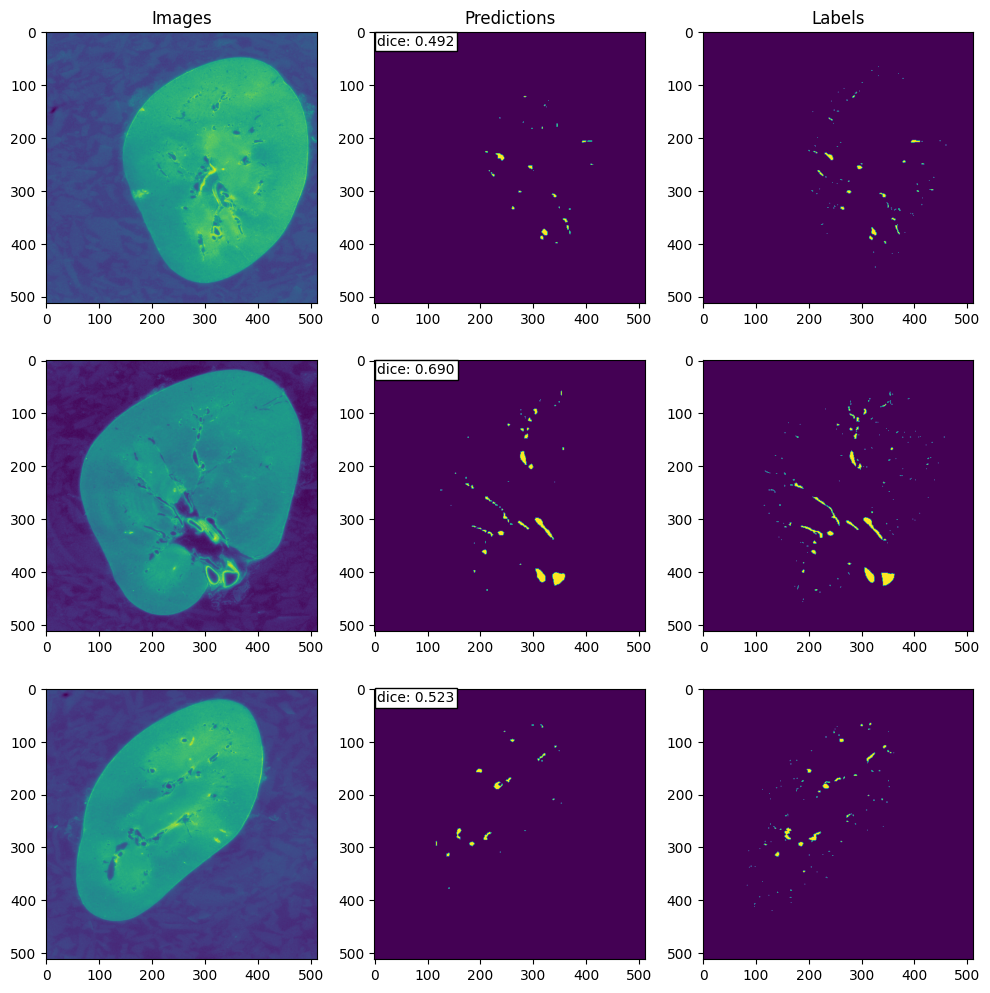

In [44]:
# Test the trained segformer model

with torch.no_grad():

    model.eval()

    segs = []
    dices = []
    images = []
    masks = []

    for i in range(0, 3):
        image, mask = valds.__getitem__(i)
        #image, _ = teds.__getitem__(i)

        #mask = np.zeros((1, 1, 512, 512))

        images.append(image)
        masks.append(mask)

    for image, mask in zip(images, masks):
        image = image.to(device)
        mask = mask.to(device)

        image = torch.unsqueeze(image, 0)
        mask = torch.unsqueeze(mask, 0)
        outputs = model(pixel_values=image, labels=mask)
        logits = outputs[0].cpu()
        mask = mask.cpu()

        seg, dice = decodeSegformer(logits, mask)

        dices.append(dice)
        segs.append(seg)

    # Convert images and labels back to device
    images = [x.cpu().numpy() for x in images]
    masks =  [x.cpu().numpy() for x in masks]

    # Show examples
    fig, ax = plt.subplots(3, 3, figsize = (10, 10))
    fig.tight_layout() # Make plot look better

    ax[0,0].set_title('Images')
    ax[0,1].set_title('Predictions')
    ax[0,2].set_title('Labels')

    # Images
    ax[0,0].imshow(images[0][0])
    ax[1,0].imshow(images[1][0])
    ax[2,0].imshow(images[2][0])

    # Predictions
    ax[0,1].imshow(np.squeeze(segs[0]))
    ax[0,1].text(5, 25, f'dice: {dices[0].item():.3f}', bbox={'facecolor': 'white', 'pad': 2})
    ax[1,1].imshow(np.squeeze(segs[1]))
    ax[1,1].text(5, 25, f'dice: {dices[1].item():.3f}', bbox={'facecolor': 'white', 'pad': 2})
    ax[2,1].imshow(np.squeeze(segs[2]))
    ax[2,1].text(5, 25, f'dice: {dices[2].item():.3f}', bbox={'facecolor': 'white', 'pad': 2})

    # Labels
    ax[0,2].imshow(masks[0])
    ax[1,2].imshow(masks[1])
    ax[2,2].imshow(masks[2])

    plt.show()

## Use Segment-Anything (SAM) to Attempt Zero-Shot Segmentation

In [45]:
# Import SAM model

checkpoint = os.path.join(os.path.join(os.getcwd(), 'model'), 'sam_vit_h_4b8939.pth')

device = 'cuda:0' if torch.cuda.is_available else 'cpu'

sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
sam.to(device=device) # Run on GPU
mask_generator = SamAutomaticMaskGenerator(sam)

In [142]:
# Grab a few items from the training set, using data_trans for submission
k1_path = os.path.join(os.path.join(os.path.join(os.path.join(os.getcwd(), 'data'), 'train'), 'kidney_1_dense'), 'images')
names = os.listdir(k1_path)
images = []

images.append(cv2.imread(os.path.join(k1_path, names[0])))
images.append(cv2.imread(os.path.join(k1_path, names[1])))
images.append(cv2.imread(os.path.join(k1_path, names[2])))

# Make prediction
totalmasks = []
for image in images:
	masks = mask_generator.generate(image)
	totalmasks.append(np.array(masks))

# Empty GPU memory
with torch.no_grad():
	torch.cuda.empty_cache()

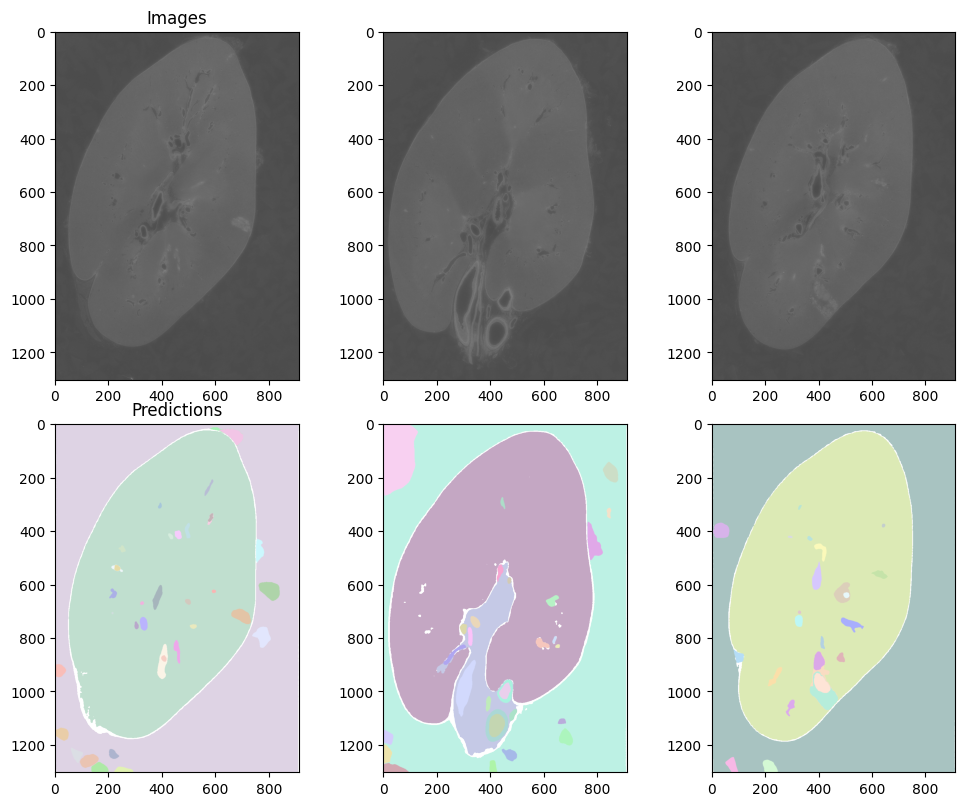

In [160]:
# From segment-anything automatic_mask_generator_example.ipynb in the FAIR Github repository
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))

    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    return img

# Show examples
fig, ax = plt.subplots(2, 3, figsize = (10, 8))
fig.tight_layout() # Make plot look better

ax[0,0].set_title('Images')
ax[1,0].set_title('Predictions')

# Images
ax[0,0].imshow(images[0])
ax[0,1].imshow(images[1])
ax[0,2].imshow(images[2])

# Predictions
ax[1,0].imshow(show_anns(totalmasks[0]))
ax[1,0].set_autoscale_on(False)
ax[1,1].imshow(show_anns(totalmasks[1]))
ax[1,1].set_autoscale_on(False)
ax[1,2].imshow(show_anns(totalmasks[2]))
ax[1,2].set_autoscale_on(False)

plt.show()

### Zero-shot SAM Performance

Straight out of the box, SAM performs poorly for our vascular dataset challenge. Looking at the middle column, it is evident that some segmentation is taking place, but it isn't relevant to the vascular problem. The list of issues is summarized below. 

1. SAM needs to be prompted (bounding box, text, etc) which isn't included in our dataset. We could potentially augment bounding boxes, but the dataset doesn't seem that well suited to rectangular boxes. 
2. The structure of biological images differs heavily from "natural images". Examples: Different collection modaltiies (X-Ray, ultrasound, etc), No color features (images are grayscale upscaled to RGB)
3. SAM is performing instance segmentation, but we have a binary segmentation problem
4. SAM does not have knowledge of the vascular problem we are trying to solve.

Conclusion:  
Problem one is the biggest issue for the given dataset. Generating bounding boxes seems difficult given the structure of the segmentation maps. Problems 2-4 could be solved by fine tuning SAM. 